In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns
pd.set_option('display.max_columns', None)
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('.')
sys.path.append('./scripts')
from competing_methods_local import *
from simulations_util import *
from util import  apply_splitting_strategy
from sklearn.preprocessing import StandardScaler

/accounts/projects/binyu/zhongyuan_liang/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = 'lightgrey'

In [4]:
# /scratch/users/zhongyuan_liang/results

### Classification

In [ ]:
task = "classification" 
combined_df = pd.DataFrame()
datasets = ["openml_43", "openml_361062", "openml_361071", "openml_9978", "openml_361069", "openml_361063"]
for data in datasets:
    ablation_directory =f"/scratch/users/zhongyuan_liang/results_selected_03_30/mdi_local.real_data_{task}_{data}/{data}_selection/varying_sample_row_n"
    split_seeds = [1,2,3,4]
    sample_seeds = [1,2,3,4,5]
    for split_seed in split_seeds:
        for sample_seed in sample_seeds:
            try:
                df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{sample_seed}/results.csv"))
                df["data"] = data
                combined_df = pd.concat([combined_df, df], ignore_index=True)
            except:
                print(f"missing {data} {split_seed} {sample_seed}")

In [34]:
methods = [
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus',    
    'MDI',
    'MDI+',
    'LIME_RF',
    'TreeSHAP_RF',
]
color_map = {
    'LIME_RF': '#71BEB7',
    'TreeSHAP_RF': 'orange',
    'MDI': '#9B5DFF',
    'MDI+': 'red',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'black'
}

# data_name = {
#     "openml_43": "Spam",
#     "openml_9946": "Breast Cancer",
#     "openml_9978": "Ozone",
#     "openml_146819": "Climate",
#     "openml_361062": "Pol",
#     "openml_361070": "Eye Movement",
# }
data_name = {
    "openml_43": "Spam",
    "openml_361062": "Pol",
    "openml_361071": "Jannis",
    "openml_9978": "Ozone",
    "openml_361069": "Higgs",
    "openml_361063": "House 16H"
}

methods_name = {
    'LIME_RF': 'LIME',
    'MDI': 'bLoTLA',
    'MDI+': 'MDI+',
    'TreeSHAP_RF': 'TreeSHAP',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'LoTLA',
}

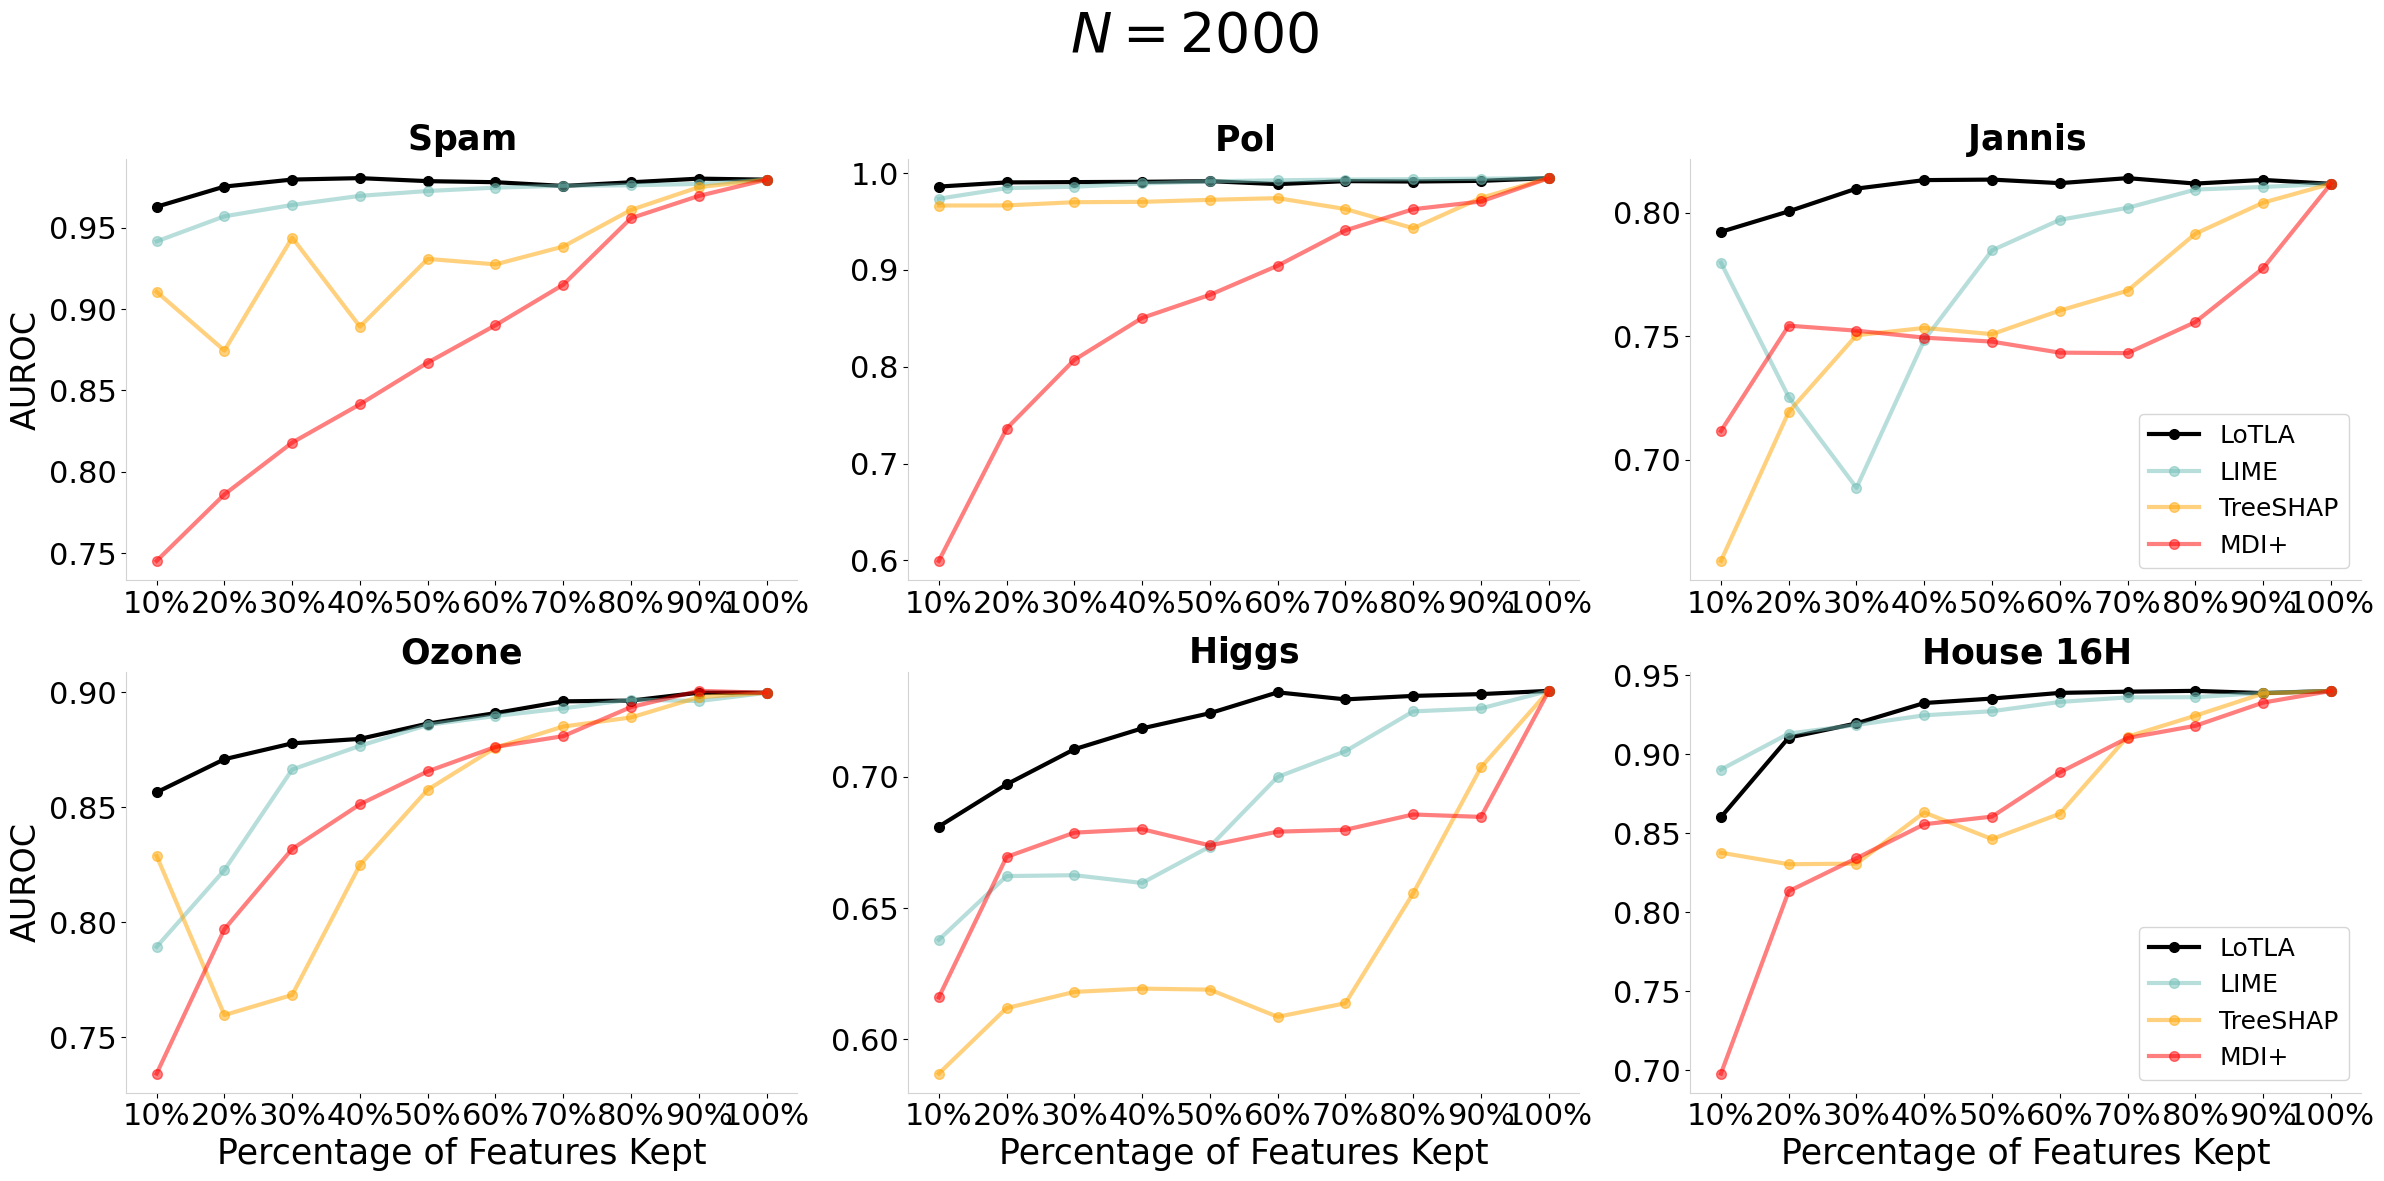

In [37]:
df = combined_df[combined_df["sample_row_n"] == 2000]  
datasets = df["data"].unique()

marker_size = 7
dotted_methods = ['LIME_RF', 'TreeSHAP_RF', 'MDI']  # This is retained in case you need it later

# Determine number of rows and columns
n_cols = 3
n_rows = 2#len(datasets) // n_cols

# Create subplots
fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(8 * n_cols, 6 * n_rows),
    sharey=False
)

# Flatten axes for easier indexing
axs = axs.flatten()

# Loop through each dataset
for idx, dataset in enumerate(datasets):
    ax = axs[idx]
    subset = df[df["data"] == dataset]
    
    # Plot results for each method
    for method in ['Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus','LIME_RF','TreeSHAP_RF', 'MDI+']:
        method_data = subset[subset["fi"] == method]
        results = method_data[
            ["RF_Classifier_AUROC_top_0.1", "RF_Classifier_AUROC_top_0.2", "RF_Classifier_AUROC_top_0.3", "RF_Classifier_AUROC_top_0.4",
                "RF_Classifier_AUROC_top_0.5", "RF_Classifier_AUROC_top_0.6", "RF_Classifier_AUROC_top_0.7", "RF_Classifier_AUROC_top_0.8", 
                "RF_Classifier_AUROC_top_0.9", "RF_Classifier_AUROC_top_1.0"]
        ].mean(axis=0).values
        
        if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI', 'MDI+']:
            ax.plot(
                [0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8,0.9,1.0], results,
                label=methods_name[method], linestyle='solid',  # Only dotted lines
                marker='o', markersize=marker_size, color=color_map[method], linewidth=3, alpha=0.5
            )
        else:
            ax.plot(
                [0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8,0.9,1.0], results,
                label=methods_name[method], linestyle='solid',  # Only solid lines
                marker='o', markersize=marker_size, color=color_map[method], linewidth=3
            )
    
    # Set x-axis and labels
    ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_xticklabels(["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%","90%", "100%"], fontsize=22)
    ax.tick_params(axis='y', labelsize=22)
    if idx >= (n_rows - 1) * n_cols:
        ax.set_xlabel("Percentage of Features Kept", fontsize=25)
    
    # Only set y-axis label for the first plot in each row
    if idx % n_cols == 0:
        ax.set_ylabel("AUROC", fontsize=24)
    else:
        ax.set_ylabel("")
    
    # Set subplot title
    dataset_label = data_name[dataset].replace(' ', r'\ ')
    ax.set_title(f"$\\mathbf{{{dataset_label}}}$", fontsize=25)
    
    # Add legend to the last plot in each row
    if (idx + 1) % n_cols == 0 or idx == len(datasets) - 1:
        ax.legend(fontsize=18, loc='lower right')

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.suptitle(
    r"$N=2000$", 
    fontsize=40,
    ha='center',
    fontweight='bold'
)
# plt.savefig("feature_selection_classification_500.png")
plt.show()

In [22]:
# task = "classification" 
# combined_df = pd.DataFrame()
# datasets = ["openml_9946"] 
# # ["openml_146819", "openml_361070","openml_9946","openml_43","openml_361062","openml_9978"]
# for data in datasets:
#     ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}/{data}_selection/varying_sample_row_n"
#     split_seeds = [1,2,3,4]
#     sample_seeds = [1,2,3,4,5]
#     for split_seed in split_seeds:
#         for sample_seed in sample_seeds:
#             df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{sample_seed}/results.csv"))
#             df["data"] = data
#             combined_df = pd.concat([combined_df, df], ignore_index=True)

In [23]:
# methods = [
#     'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus',    
#     'MDI',
#     'MDI+',
#     'LIME_RF',
#     'TreeSHAP_RF',
# ]
# color_map = {
#     'LIME_RF': '#71BEB7',
#     'TreeSHAP_RF': 'orange',
#     'MDI': '#9B5DFF',
#     'MDI+': 'red',
#     'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'black'
# }

# data_name = {
#     "openml_361062": "361062",
#     "openml_361063": "361063",
#     "openml_361064": "361064",
#     "openml_361068": "361068",
#     "openml_361069": "361069",
#     "openml_361070": "361070",
#     "openml_361071": "361071",
#     "openml_9946": "9946"
# }

# methods_name = {
#     'LIME_RF': 'LIME',
#     'MDI': 'bLoTLA',
#     'MDI+': 'MDI+',
#     'TreeSHAP_RF': 'TreeSHAP',
#     'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'LoTLA',
# }

In [24]:
# df = combined_df[combined_df["sample_row_n"] == 2000]  
# datasets = df["data"].unique()

# marker_size = 7
# dotted_methods = ['LIME_RF', 'TreeSHAP_RF', 'MDI']  # This is retained in case you need it later

# # Determine number of rows and columns
# n_cols = 3
# n_rows = 3#len(datasets) // n_cols

# # Create subplots
# fig, axs = plt.subplots(
#     nrows=n_rows,
#     ncols=n_cols,
#     figsize=(8 * n_cols, 6 * n_rows),
#     sharey=False
# )

# # Flatten axes for easier indexing
# axs = axs.flatten()

# # Loop through each dataset
# for idx, dataset in enumerate(datasets):
#     ax = axs[idx]
#     subset = df[df["data"] == dataset]
    
#     # Plot results for each method
#     for method in ['Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus','MDI','LIME_RF','TreeSHAP_RF']:
#         method_data = subset[subset["fi"] == method]
#         results = method_data[
#             ["RF_Classifier_AUROC_top_0.1", "RF_Classifier_AUROC_top_0.2", "RF_Classifier_AUROC_top_0.3", "RF_Classifier_AUROC_top_0.4",
#                 "RF_Classifier_AUROC_top_0.5", "RF_Classifier_AUROC_top_0.6", "RF_Classifier_AUROC_top_0.7", "RF_Classifier_AUROC_top_0.8", 
#                 "RF_Classifier_AUROC_top_0.9", "RF_Classifier_AUROC_top_1.0"]
#         ].mean(axis=0).values
        
#         if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI', 'MDI+']:
#             ax.plot(
#                 [0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8,0.9,1.0], results,
#                 label=methods_name[method], linestyle='solid',  # Only dotted lines
#                 marker='o', markersize=marker_size, color=color_map[method], linewidth=3, alpha=0.5
#             )
#         else:
#             ax.plot(
#                 [0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8,0.9,1.0], results,
#                 label=methods_name[method], linestyle='solid',  # Only solid lines
#                 marker='o', markersize=marker_size, color=color_map[method], linewidth=3
#             )
    
#     # Set x-axis and labels
#     ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
#     ax.set_xticklabels(["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%","90%", "100%"], fontsize=22)
#     ax.tick_params(axis='y', labelsize=22)
#     if idx >= (n_rows - 1) * n_cols:
#         ax.set_xlabel("Percentage of Features Kept", fontsize=25)
    
#     # Only set y-axis label for the first plot in each row
#     if idx % n_cols == 0:
#         ax.set_ylabel("AUROC", fontsize=24)
#     else:
#         ax.set_ylabel("")
    
#     # Set subplot title
#     dataset_label = data_name[dataset].replace(' ', r'\ ')
#     ax.set_title(f"$\\mathbf{{{dataset_label}}}$", fontsize=25)
    
#     # Add legend to the last plot in each row
#     if (idx + 1) % n_cols == 0 or idx == len(datasets) - 1:
#         ax.legend(fontsize=18, loc='lower right')

# plt.tight_layout(rect=[0, 0, 1, 0.9])
# plt.suptitle(
#     r"$N=2000$", 
#     fontsize=40,
#     ha='center',
#     fontweight='bold'
# )
# # plt.savefig("feature_selection_classification_500.png")
# plt.show()

### Regression

In [4]:
task = "regression" 
combined_df = pd.DataFrame()
datasets = ["openml_361259", "openml_361260", "openml_361259", "openml_361253", "openml_361254", "openml_361242", "openml_361243"]
for data in datasets:
    ablation_directory =f"/scratch/users/zhongyuan_liang/results_03_30/mdi_local.real_data_{task}_{data}/{data}_selection/varying_sample_row_n"
    split_seeds = [1,2,3,4]
    sample_seeds = [1,2,3,4,5]
    for split_seed in split_seeds:
        for sample_seed in sample_seeds:
            try:
                df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{sample_seed}/results.csv"))
                df["data"] = data
                combined_df = pd.concat([combined_df, df], ignore_index=True)
            except:
                print(f"missing {data} {split_seed} {sample_seed}")

missing openml_361253 3 4
missing openml_361242 1 4
missing openml_361242 2 2
missing openml_361242 3 1


In [9]:
combined_df

,rep,sample_row_n,sample_row_n_name,model,fi,train_size,test_size,num_features,data_split_seed,est_r2,rf_plus_elastic_r2,rf_plus_default_r2,rf_plus_inbag_r2,rf_plus_mdi_plus_r2,rf_plus_moe_elasticnet_r2,rf_plus_moe_default_r2,rf_plus_moe_loo_default_r2,num_features_masked_0.1,RF_Regressor_R2_mask_0.1,num_features_masked_0.2,RF_Regressor_R2_mask_0.2,num_features_masked_0.3,RF_Regressor_R2_mask_0.3,num_features_masked_0.4,RF_Regressor_R2_mask_0.4,num_features_masked_0.5,RF_Regressor_R2_mask_0.5,num_features_masked_0.6,RF_Regressor_R2_mask_0.6,num_features_masked_0.7,RF_Regressor_R2_mask_0.7,num_features_masked_0.8,RF_Regressor_R2_mask_0.8,num_features_masked_0.9,RF_Regressor_R2_mask_0.9,num_features_masked_1.0,RF_Regressor_R2_mask_1.0,split_seed,data
0,0,500,500,RF,LIME_RF,335,165,32,1,0.196969,0.237104,0.235363,0.196969,0.227145,0.240622,0.237776,0.244246,4,0.193490,7,0.174950,10,0.325871,13,0.436173,16,0.436075,20,0.408588,23,0.390758,26,0.421841,29,0.417914,32,0.403923,1,openml_361259
1,0,500,500,RF,Local_MDI+_MDI_default_RFPlus_loo_moe,335,165,32,1,0.196969,0.237104,0.235363,0.196969,0.227145,0.240622,0.237776,0.244246,4,0.445699,7,0.502551,10,0.462323,13,0.438198,16,0.456888,20,0.424210,23,0.397316,26,0.407798,29,0.397450,32,0.403923,1,openml_361259
2,0,500,500,RF,Local_MDI+_MDI_default_RFPlus_moe,335,165,32,1,0.196969,0.237104,0.235363,0.196969,0.227145,0.240622,0.237776,0.244246,4,0.514223,7,0.486260,10,0.404848,13,0.424414,16,0.442112,20,0.385229,23,0.416240,26,0.398026,29,0.408064,32,0.403923,1,openml_361259
3,0,500,500,RF,Local_MDI+_MDI_default_fit_on_all_ranking_RFPlus,335,165,32,1,0.196969,0.237104,0.235363,0.196969,0.227145,0.240622,0.237776,0.244246,4,0.350568,7,0.458075,10,0.451397,13,0.380482,16,0.401027,20,0.414675,23,0.415942,26,0.402148,29,0.401366,32,0.403923,1,openml_361259
4,0,500,500,RF,Local_MDI+_MDI_elasticnet_RFPlus_moe,335,165,32,1,0.196969,0.237104,0.235363,0.196969,0.227145,0.240622,0.237776,0.244246,4,0.383432,7,0.424624,10,0.451079,13,0.409186,16,0.400575,20,0.350460,23,0.399012,26,0.424630,29,0.416581,32,0.403923,1,openml_361259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,0,2000,2000,RF,Local_MDI+_MDI_elasticnet_RFPlus_moe,709,350,72,4,0.277599,0.268927,0.269064,0.277599,0.263147,0.258905,0.260321,0.264638,8,0.118771,15,0.097907,22,-0.126880,29,-0.111369,36,0.197095,44,0.206110,51,0.224496,58,0.245643,65,0.240404,72,0.268101,4,openml_361243
3668,0,2000,2000,RF,Local_MDI+_MDI_elasticnet_fit_on_all_ranking_R...,709,350,72,4,0.277599,0.268927,0.269064,0.277599,0.263147,0.258905,0.260321,0.264638,8,0.197240,15,0.092986,22,0.125319,29,0.211813,36,0.235176,44,0.231692,51,0.260989,58,0.268843,65,0.262519,72,0.268101,4,openml_361243
3669,0,2000,2000,RF,MDI+,709,350,72,4,0.277599,0.268927,0.269064,0.277599,0.263147,0.258905,0.260321,0.264638,8,0.207529,15,0.241042,22,0.243325,29,0.244570,36,0.237415,44,0.252994,51,0.278043,58,0.271075,65,0.269728,72,0.268101,4,openml_361243
3670,0,2000,2000,RF,MDI,709,350,72,4,0.277599,0.268927,0.269064,0.277599,0.263147,0.258905,0.260321,0.264638,8,0.118761,15,0.178553,22,0.091621,29,0.188979,36,0.188654,44,0.241563,51,0.266884,58,0.262290,65,0.259455,72,0.268101,4,openml_361243


In [10]:
combined_df.groupby(["data", "sample_row_n"])[["est_r2", "rf_plus_elastic_r2",  "rf_plus_default_r2", "rf_plus_moe_elasticnet_r2", "rf_plus_moe_default_r2", "rf_plus_moe_loo_default_r2"]].mean()

est_r2  rf_plus_elastic_r2  rf_plus_default_r2  \
data          sample_row_n                                                     
openml_361242 500           0.753563            0.745847            0.756073   
              1000          0.791758            0.783760            0.792343   
              2000          0.838808            0.833343            0.840058   
openml_361243 500           0.193028            0.187268            0.187978   
              1000          0.244048            0.231175            0.237472   
              2000          0.255981            0.249004            0.258269   
openml_361253 500           0.532892            0.535042            0.870788   
              1000          0.622239            0.613690            0.983977   
              2000          0.675117            0.649709            0.998641   
openml_361254 500           0.704947            0.907217            0.912252   
              1000          0.790405            0.929278            0.931844   
              2000          0.844405            0.938671            0.941083   
openml_361259 500           0.232929            0.244613            0.243188   
              1000          0.350616            0.349776            0.348484   
              2000          0.451165            0.446201            0.444630   
openml_361260 500           0.704719            0.471883            0.778993   
              1000          0.767392            0.478814            0.809614   
              2000          0.822572            0.480988            0.846997   

                            rf_plus_moe_elasticnet_r2  rf_plus_moe_default_r2  \
data          sample_row_n                                                      
openml_361242 500                            0.742371                0.749726   
              1000                           0.781191                0.790813   
              2000                           0.832497                0.837265   
openml_361243 500                            0.101182                0.107040   
              1000                           0.196938                0.219880   
              2000                           0.224003                0.243682   
openml_361253 500                            0.627083                0.938901   
              1000                           0.702966                0.998853   
              2000                           0.748033                0.999149   
openml_361254 500                            0.910687                0.913553   
              1000                           0.931394                0.932492   
              2000                           0.940951                0.941944   
openml_361259 500                            0.254047                0.250814   
              1000                           0.361255                0.358428   
              2000                           0.450488                0.449001   
openml_361260 500                            0.530580                0.777879   
              1000                           0.548838                0.809598   
              2000                           0.552463                0.845848   

                            rf_plus_moe_loo_default_r2  
data          sample_row_n                              
openml_361242 500                             0.759881  
              1000                            0.793258  
              2000                            0.839433  
openml_361243 500                             0.098330  
              1000                            0.206741  
              2000                            0.222063  
openml_361253 500                             0.937807  
              1000                            0.998849  
              2000                            0.999155  
openml_361254 500                             0.912571  
              1000                            0.932811  
              2000                            0.942489  
openml_361

In [ ]:
# methods = [
#     'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus',    
#     'MDI',
#     'MDI+',
#     'LIME_RF',
#     'TreeSHAP_RF',
# ]
# color_map = {
#     'LIME_RF': '#71BEB7',
#     'TreeSHAP_RF': 'orange',
#     'MDI': '#9B5DFF',
#     'MDI+': 'red',
#     'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'black'
# }


# data_name = {
#     "openml_361260": "Miami Housing",
#     "openml_361259": "Puma Robot",
#     "openml_361253": "Wave Energy",
#     "openml_361254": "SARCOS",
#     "openml_361242": "Super Conductivity",
#     "openml_361243": "Geographic Origin of Music"
# }

# methods_name = {
#     'LIME_RF': 'LIME',
#     'MDI': 'bLoTLA',
#     'MDI+': 'MDI+',
#     'TreeSHAP_RF': 'TreeSHAP',
#     'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'LoTLA',
# }

In [6]:
methods = [
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus',
    'Local_MDI+_MDI_default_fit_on_all_ranking_RFPlus',
    'Local_MDI+_MDI_elasticnet_RFPlus_moe',
    'Local_MDI+_MDI_default_RFPlus_moe',
    'Local_MDI+_MDI_default_RFPlus_loo_moe',
    # 'MDI',
    # 'MDI+',
    'LIME_RF',
    'TreeSHAP_RF',
]

color_map = {
    'LIME_RF': '#1F77B4',  # Blue
    'TreeSHAP_RF': '#FF7F0E',  # Orange
    # 'MDI': '#2CA02C',  # Green
    # 'MDI+': '#D62728',  # Red
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': '#000000',  # Black
    'Local_MDI+_MDI_default_RFPlus_loo_moe': '#9467BD',  # Purple
    'Local_MDI+_MDI_default_RFPlus_moe': '#8C564B',  # Brown
    'Local_MDI+_MDI_default_fit_on_all_ranking_RFPlus': '#E377C2',  # Pink
    'Local_MDI+_MDI_elasticnet_RFPlus_moe': '#7F7F7F',  # Gray
}

data_name = {
    "openml_361622": "361622",
    "openml_361260": "361260",
    "openml_361259": "361259",
    "openml_361253": "361253",
    "openml_361254": "361254",
    "openml_361242": "361242",
    "openml_361243": "361243"
}

methods_name = {
    'LIME_RF': 'LIME',
    # 'MDI': 'bLoTLA',
    # 'MDI+': 'MDI+',
    'TreeSHAP_RF': 'TreeSHAP',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'LoTLA-CV',
    'Local_MDI+_MDI_default_fit_on_all_ranking_RFPlus': 'LoTLA-LOO',
    'Local_MDI+_MDI_elasticnet_RFPlus_moe': 'LoTLA-CV-MOE',
    'Local_MDI+_MDI_default_RFPlus_moe': 'LoTLA-LOO-MOE',
    'Local_MDI+_MDI_default_RFPlus_loo_moe': 'LoTLA-LOO-MOE-LOO',
}

/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


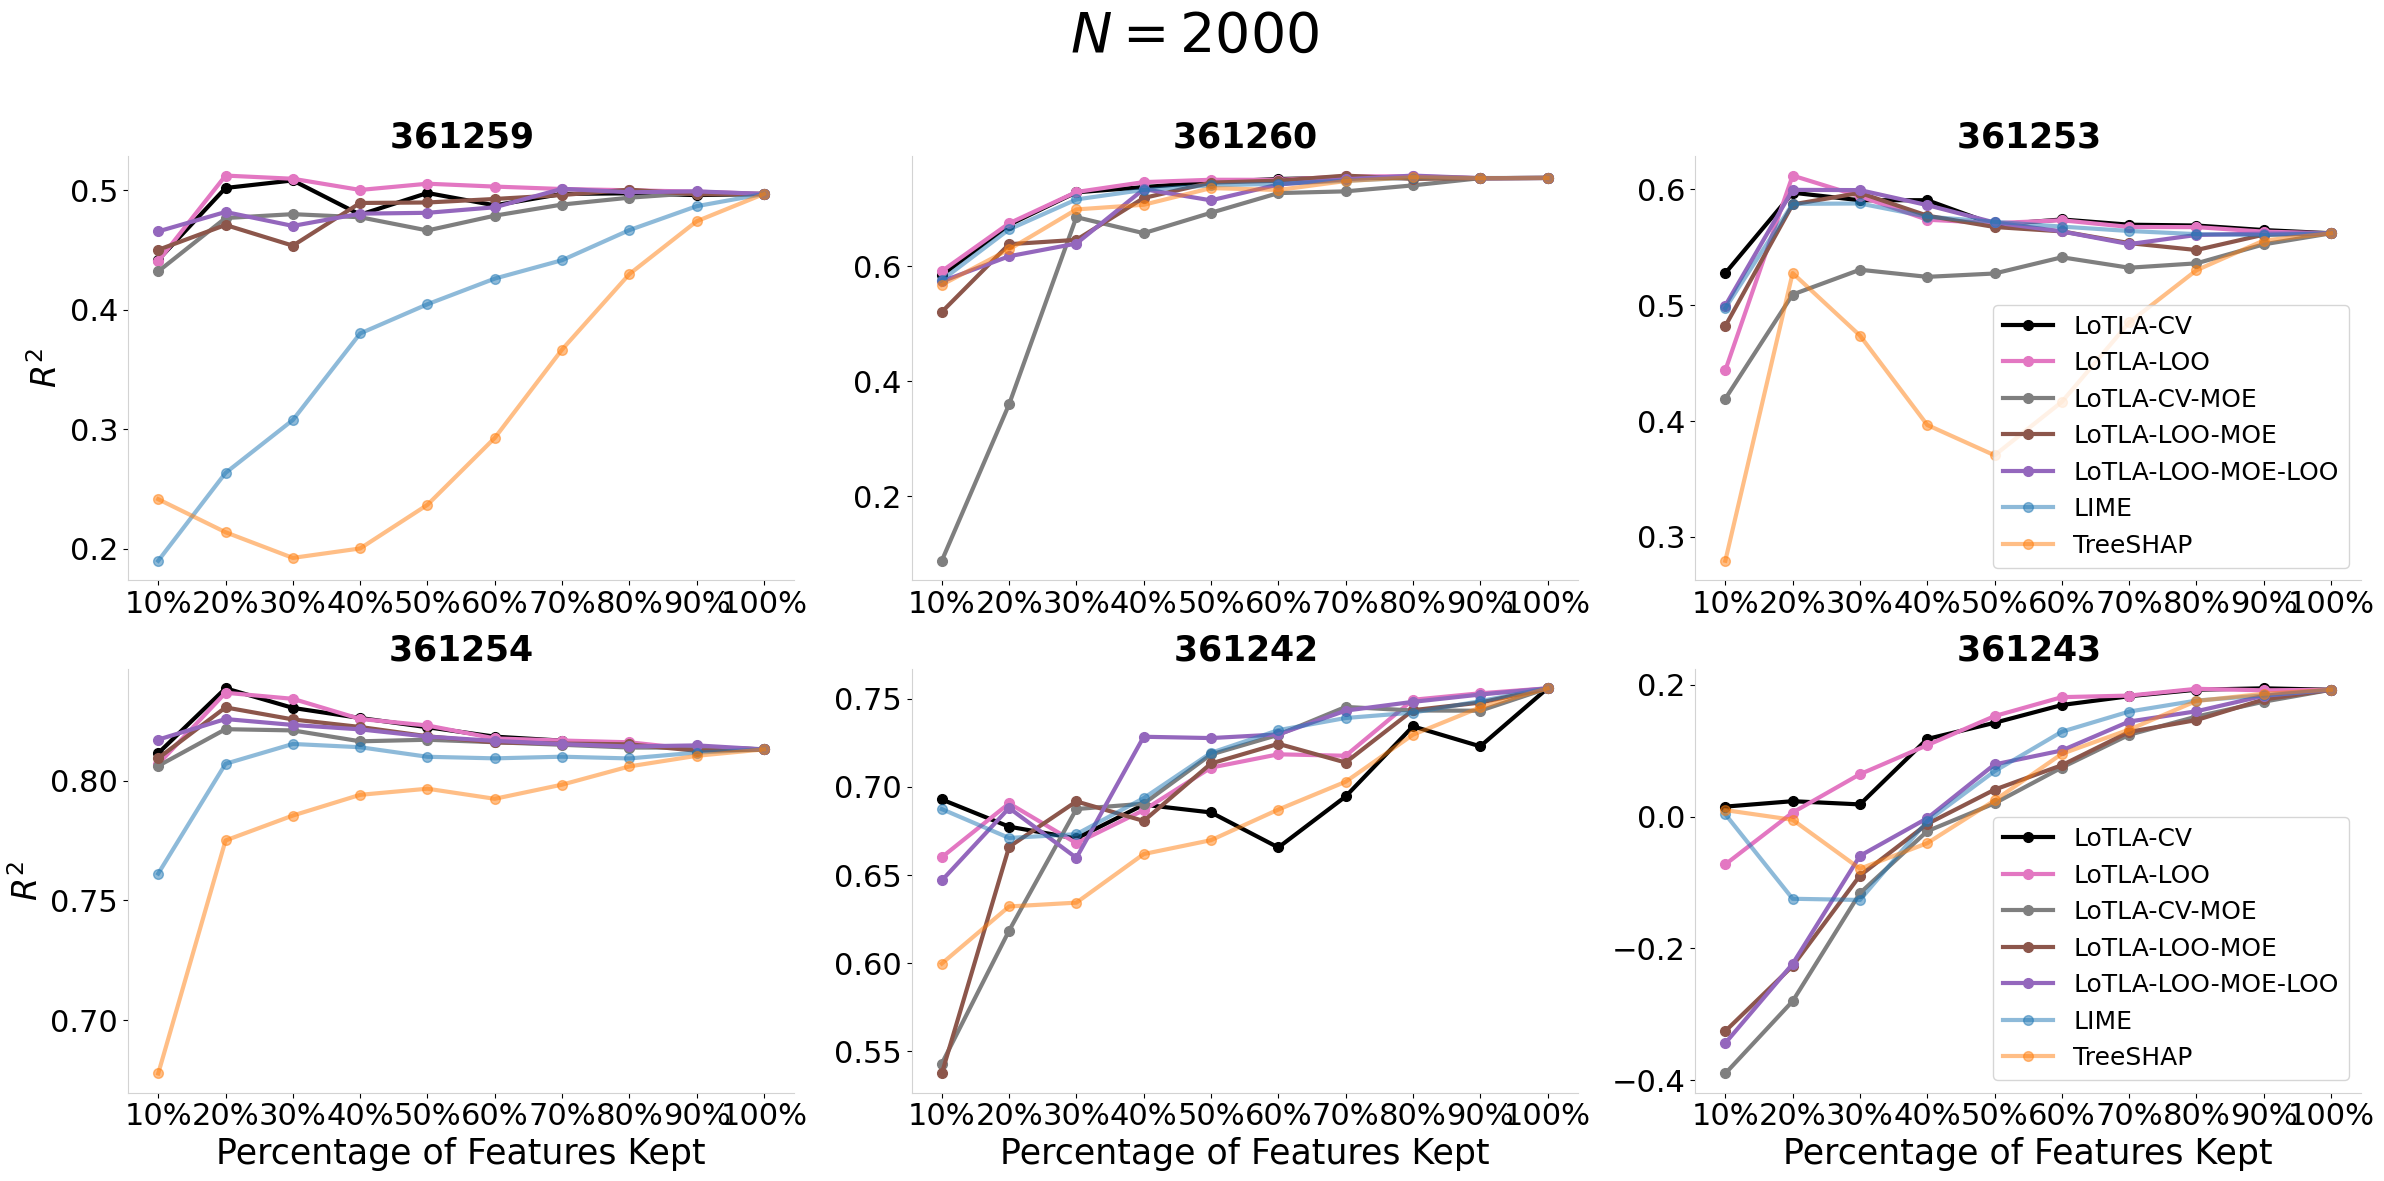

In [7]:
df = combined_df[combined_df["sample_row_n"] == 500]  
datasets = df["data"].unique()

marker_size = 7

# Determine number of rows and columns
n_cols = 3
n_rows = 2  # len(datasets) // n_cols

# Create subplots
fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(8 * n_cols, 6 * n_rows),
    sharey=False
)

# Flatten axes for easier indexing
axs = axs.flatten()

# Loop through each dataset
for idx, dataset in enumerate(datasets):
    ax = axs[idx]
    subset = df[df["data"] == dataset]
    
    # Plot results for each method
    for method in methods: #['Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus','LIME_RF','TreeSHAP_RF', 'MDI+']:
        method_data = subset[subset["fi"] == method]
        results = method_data[
            ["RF_Regressor_R2_mask_0.1", "RF_Regressor_R2_mask_0.2", "RF_Regressor_R2_mask_0.3",
            "RF_Regressor_R2_mask_0.4", "RF_Regressor_R2_mask_0.5", "RF_Regressor_R2_mask_0.6", "RF_Regressor_R2_mask_0.7",
            "RF_Regressor_R2_mask_0.8", "RF_Regressor_R2_mask_0.9", "RF_Regressor_R2_mask_1.0"]
        ].mean(axis=0).values
        
        if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI', 'MDI+']:
            ax.plot(
                [0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8,0.9,1.0], results,
                label=methods_name[method], linestyle='solid',  # Only solid lines
                marker='o', markersize=marker_size, color=color_map[method], linewidth=3, alpha=0.5
            )
        else:
            ax.plot(
                [0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8,0.9,1.0], results,
                label=methods_name[method], linestyle='solid',  # Only solid lines
                marker='o', markersize=marker_size, color=color_map[method], linewidth=3
            )
    
    # Set x-axis and labels
    ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_xticklabels(["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%","90%", "100%"], fontsize=22)
    ax.tick_params(axis='y', labelsize=22)    
    if idx >= (n_rows - 1) * n_cols:
        ax.set_xlabel("Percentage of Features Kept", fontsize=25)
    
    # Only set y-axis label for the first plot in each row
    if idx % n_cols == 0:
        ax.set_ylabel(r"$R^2$", fontsize=24)
    else:
        ax.set_ylabel("")
    
    # Set subplot title
    dataset_label = data_name[dataset].replace(' ', r'\ ')
    ax.set_title(f"$\\mathbf{{{dataset_label}}}$", fontsize=25)
    
    # Add legend to the last plot in each row
    if (idx + 1) % n_cols == 0 or idx == len(datasets) - 1:
        ax.legend(fontsize=18, loc='lower right')

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.suptitle(
    r"$N=2000$", 
    fontsize=40,
    ha='center',
    fontweight='bold'
)
# plt.savefig("feature_selection_regression_500.png")
plt.show()

In [ ]:
df = combined_df[combined_df["sample_row_n"] == 500]  
datasets = df["data"].unique()

marker_size = 7

# Determine number of rows and columns
n_cols = 3
n_rows = 2  # len(datasets) // n_cols

# Create subplots
fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(8 * n_cols, 6 * n_rows),
    sharey=False
)

# Flatten axes for easier indexing
axs = axs.flatten()

# Loop through each dataset
for idx, dataset in enumerate(datasets):
    ax = axs[idx]
    subset = df[df["data"] == dataset]
    
    # Plot results for each method
    for method in methods: #['Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus','LIME_RF','TreeSHAP_RF', 'MDI+']:
        method_data = subset[subset["fi"] == method]
        results = method_data[
            ["RF_Regressor_R2_mask_0.1", "RF_Regressor_R2_mask_0.2", "RF_Regressor_R2_mask_0.3",
            "RF_Regressor_R2_mask_0.4", "RF_Regressor_R2_mask_0.5", "RF_Regressor_R2_mask_0.6", "RF_Regressor_R2_mask_0.7",
            "RF_Regressor_R2_mask_0.8", "RF_Regressor_R2_mask_0.9", "RF_Regressor_R2_mask_1.0"]
        ].mean(axis=0).values
        
        if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI', 'MDI+']:
            ax.plot(
                [0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8,0.9,1.0], results,
                label=methods_name[method], linestyle='solid',  # Only solid lines
                marker='o', markersize=marker_size, color=color_map[method], linewidth=3, alpha=0.5
            )
        else:
            ax.plot(
                [0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8,0.9,1.0], results,
                label=methods_name[method], linestyle='solid',  # Only solid lines
                marker='o', markersize=marker_size, color=color_map[method], linewidth=3
            )
    
    # Set x-axis and labels
    ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_xticklabels(["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%","90%", "100%"], fontsize=22)
    ax.tick_params(axis='y', labelsize=22)    
    if idx >= (n_rows - 1) * n_cols:
        ax.set_xlabel("Percentage of Features Kept", fontsize=25)
    
    # Only set y-axis label for the first plot in each row
    if idx % n_cols == 0:
        ax.set_ylabel(r"$R^2$", fontsize=24)
    else:
        ax.set_ylabel("")
    
    # Set subplot title
    dataset_label = data_name[dataset].replace(' ', r'\ ')
    ax.set_title(f"$\\mathbf{{{dataset_label}}}$", fontsize=25)
    
    # Add legend to the last plot in each row
    if (idx + 1) % n_cols == 0 or idx == len(datasets) - 1:
        ax.legend(fontsize=18, loc='lower right')

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.suptitle(
    r"$N=2000$", 
    fontsize=40,
    ha='center',
    fontweight='bold'
)
# plt.savefig("feature_selection_regression_500.png")
plt.show()